In [172]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session


(26304, 60)
(26304, 12, 5)


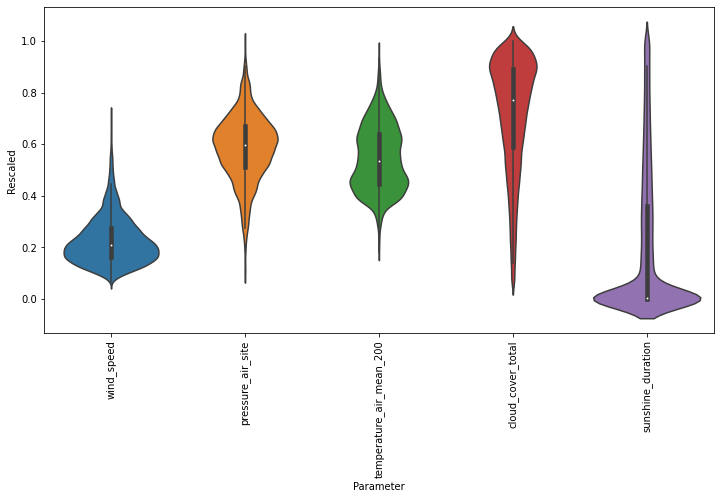

In [185]:
parameters = ["wind_speed", "pressure_air_site", "temperature_air_mean_200", "cloud_cover_total", "sunshine_duration"]
parameter=parameters[0]
# print(parameter)
# path="../data/weather/"+parameters[0]+"_2021.pkl"
# weather = pd.read_pickle(path)

def load_weatherdata(parameters):
    means = pd.DataFrame()
    weather = pd.DataFrame()
    weather_array = []
    scaler_dict={}
    for parameter in parameters:
        scaler = MinMaxScaler()
        path="../data/weather/scaled/"+parameter+".pkl"
        import_df = pd.read_pickle(path)
        import_df.clip(lower=-4, upper=None, inplace=True)
        index = import_df.index
        columns = import_df.columns
        column_list=columns.tolist()
        scaled = pd.DataFrame(data = scaler.fit_transform(import_df), index=index, columns=columns)
        means[parameter] = scaled.mean(axis=1)
        weather = pd.concat([weather, scaled], axis=1)
        weather_array.append(scaled.to_numpy())
        # scaler_dict[parameter] = scaler
    # print(weather.head())
    return weather, means, scaler_dict, np.array(weather_array).swapaxes(0,1).swapaxes(1,2), columns.tolist()
# w2 = weather.melt(var_name='Column', value_name='Rescaled')

df, means, scalers, w_array, columns = load_weatherdata(parameters)
print(df.to_numpy().shape)
print(w_array.shape)
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Parameter", y="Rescaled", data=means.melt(var_name='Parameter', value_name='Rescaled'))
_ = ax.set_xticklabels(means.keys(), rotation=90)

In [186]:
X = df.to_numpy()
testsplit = int(0.8*X.shape[0])
X_train = X[:testsplit]
X_test  = X[testsplit:]

input_dim = X_train.shape[1]
# this fixes the latent space dimension, feel free to play around with
# the values for your own experiments, but leave it at 2 for the assignment
latent_dim = 4
print(input_dim)
print(X_train.shape)
print(X.dtype)

60
(21043, 60)
float64


In [187]:
from tensorflow.keras.backend import clear_session

clear_session()

# this is very similar to what we've done before. First, instantiate a
# "Sequential()" model in a variable called "shallow_ae". Then, add a
# "Dense()" layer to shallow_ae with latent_dim neurons, an appropriate "input_shape"
# and activation "relu". Afterwards, add another Dense layer with an appropriate
# number of neurons to be able to construct an MNIST image and "sigmoid"
# activation.
# YOUR CODE HERE
shallow_ae=Sequential()
shallow_ae.add(Dense(latent_dim, input_shape=[input_dim],  activation='sigmoid'))
shallow_ae.add(Dense(X_train.shape[1], activation='sigmoid'))

shallow_ae.summary()

# plot_model(shallow_ae)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 244       
                                                                 
 dense_1 (Dense)             (None, 60)                300       
                                                                 
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


In [188]:
# create an input layer with the appropriate shape
input_img = Input(shape=(input_dim,))
input_lat = Input(shape=(latent_dim,))

# extract the first shallow_ae layer
encoder_layer = shallow_ae.layers[0]
decoder_layer = shallow_ae.layers[-1]

# make them addressable models
shallow_encoder = Model(input_img, encoder_layer(input_img))
shallow_decoder = Model(input_lat, decoder_layer(input_lat))

shallow_encoder.summary()
shallow_decoder.summary()

# #plot_model(shallow_encoder)
# plot_model(shallow_decoder)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 4)                 244       
                                                                 
Total params: 244
Trainable params: 244
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_1 (Dense)             (None, 60)                300       
                                                                 
Total params: 300
Trainable params: 300
Non-tr

In [191]:
shallow_ae.compile(optimizer="adam", loss="mse")
history=shallow_ae.fit(X_train, X_train, epochs=10, batch_size=256, shuffle=True, validation_split=0.3)

Epoch 1/10
58/58 [==============================] - 1s 4ms/step - loss: 0.0553 - val_loss: 0.0474
Epoch 2/10
58/58 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0462
Epoch 3/10
58/58 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0450
Epoch 4/10
58/58 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0439
Epoch 5/10
58/58 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0427
Epoch 6/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0417
Epoch 7/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0408
Epoch 8/10
58/58 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0399
Epoch 9/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0391
Epoch 10/10
58/58 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0383


In [190]:
print(shallow_ae.predict(X_test))

[[0.28259292 0.25533056 0.1609191  ... 0.17946476 0.20105252 0.18717384]
 [0.27923733 0.24919716 0.15279213 ... 0.16983628 0.19344702 0.17716649]
 [0.27976504 0.25005025 0.15384203 ... 0.17105761 0.19445375 0.17843485]
 ...
 [0.279117   0.24860269 0.15214178 ... 0.16879001 0.19335285 0.176456  ]
 [0.27852368 0.24858606 0.1516391  ... 0.1684972  0.19265899 0.17563406]
 [0.27814317 0.24849856 0.15180537 ... 0.16888896 0.19254076 0.1759223 ]]


In [204]:
# (x_train, _), (x_test, _) = fashion_mnist.load_data()

clear_session()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
testsplit=int(w_array.shape[0]*2/3)
np.nan_to_num(w_array, copy=False, nan=0.0)
x_train = w_array[:testsplit].astype('float32')
x_test = w_array[testsplit:].astype('float32')

print (x_train.shape)
print (x_test.shape)
# print(x_train[11])
# assert not np.any(np.isnan(w_array))

len(np.argwhere(np.isnan(w_array)))


(17536, 12, 5)
(8768, 12, 5)


0

In [205]:
latent_dim = 15

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(x_train.shape[1]*x_train.shape[2], activation='sigmoid'),
      layers.Reshape((x_train.shape[1], x_train.shape[2]))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
clear_session()
autoencoder = Autoencoder(latent_dim)

In [206]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0444 - val_loss: 0.0266
Epoch 2/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0222 - val_loss: 0.0188
Epoch 3/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0142
Epoch 4/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0126 - val_loss: 0.0118
Epoch 5/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 6/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 7/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 8/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 9/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 10/10
548/548 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 0.0076

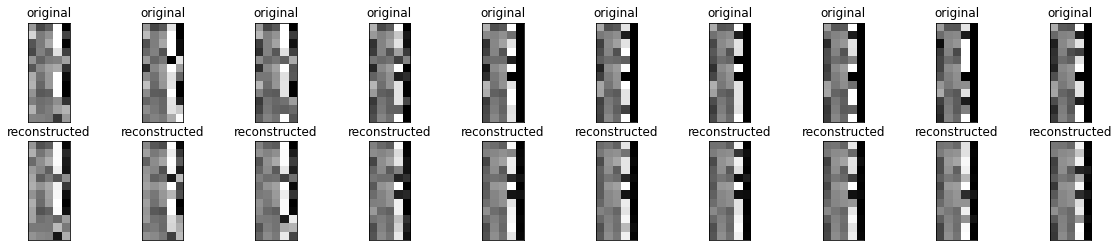

In [208]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10
offset=3000
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i+offset])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i+offset])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
